In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Est-ce que le sommet est visible ?


Afin de restreindre la recherche des sommets aux seuls visibles, on a besoin d'une fonction qui évalue la topographie du terrain sur la ligne droite jusqu'au sommet. 

### Obtenir les données

Le plus simple est d'utiliser les données SRTM: https://earthexplorer.usgs.gov/  
Ce site web propose une interface de visualisation et de téléchargement des bonnes tuiles.
Mais il y a des trous dans les données, surtout dans la région du Mont-Blanc ... en fait il n'y a pas le Mont-Blanc, ce qui est plutôt gênant ici ...


On trouve sur le wiki de OSM une liste des autres sources SRTM existantes: http://wiki.openstreetmap.org/wiki/SRTM

J'ai finalement utilisé les données de [VIEWFINDER PANORAMAS](http://www.viewfinderpanoramas.org/dem3.html#alps). Elles sont à priori libre pour un usage libre. 

La résolution est de 1 arc-sec (30m), et il n'y a pas de trous.

Rq: Il existe aussi des données européennes mais les fichiers font 2.8Gb...  [EU-DEM](https://www.eea.europa.eu/data-and-maps/data/eu-dem#tab-european-data)

Les tuiles utilisées pour les Alpes sont :  

    N44E005.hgt  N44E006.hgt  N45E005.hgt  N45E006.hgt
    
Elles sont combinées en un fichier unique grâce à la commande suivante :

    gdal_merge.py *.hgt -o merged_1arc.hgt

On obtient cette image :  (je l'ai enregistrée parce que mon ordi freeze quelques minutes pour l'afficher)
![elevation_map_1arc](./images/elevation_map_1arc.png)

### Traiter les données avec Python

Je pensais utiliser `georaster`:  https://pypi.python.org/pypi/georasters/  ... mais il ne s'installe pas (facilement) en virtual env. du fait de la librairie `gdal`

Il y a sur stackoverflow une [solution pour installer GDAL en Virtualenv](https://stackoverflow.com/questions/32066828/install-gdal-in-virtualenvwrapper-environment), qui fonctionne chez moi, en gérant les numéros de versions.

    sudo apt-get install libgdal1i libgdal1-dev libgdal-dev
    pip install pygdal==2.1.3.3


In [15]:
from osgeo import gdal

In [16]:
# Chargement du fichier

filename = 'elevation_data/viewfinderdata/merged_1arc.hgt'  # cf http://www.viewfinderpanoramas.org/dem3.html#alps
dataset = gdal.Open(filename)

# Calcul du profil entre deux points 

In [17]:
R = 6371.009 # km, rayon moyen de la terre

In [18]:
#coordsA = (5.7103223, 45.1973288) # gre
coordsA = (5.6394189, 45.1475075) # Moucherotte
coordsA = (5.7578016, 45.252951) # L'écoutoux

#coordsB = (6.858996564, 45.833496666) # Mont Blanc
#coordsB = (5.7334702, 45.218456) # Rachais
coordsB = (5.7205577, 45.2671104) # aiguille de Quaix

In [19]:
""" Transformation des coordonnés (lon, lat) en degrée decimaux  vers les pixels
    et inversement
""" 
transf = dataset.GetGeoTransform()
transfInv = gdal.InvGeoTransform(transf)

def to_px( coords ):
    px = gdal.ApplyGeoTransform(transfInv, *coords)
    return [ int( x ) for x in px ]

def to_deg( pxy ):
    return gdal.ApplyGeoTransform(transf, *pxy )

In [20]:
# - test - 
px = to_px( coordsA )
print( px )

print( to_deg( px ) )

[2728, 2689]
[5.75763888888889, 45.253194444444446]


In [21]:
""" Permet d'obtenir l'altitude d'un point   en mètre
    xy: tuple coordonnées en pixel
"""

band = dataset.GetRasterBand(1)
elevation = band.ReadAsArray()

def get_ele( xy ):
    return elevation[ xy[1] , xy[0] ]

In [22]:
def torad( theta ):
    return theta * np.pi / 180.0

def get_theta( lon1, lat1, lon2, lat2 ):
    """ Calcul l'angle entre deux positions sur terre
    """
    lat1, lon1, lat2, lon2 = [ torad(theta) for theta in [lat1, lon1, lat2, lon2] ]
    cosTheta =  np.sin( lat1 )*np.sin( lat2 ) + np.cos( lat1 )*np.cos( lat2 )*np.cos( lon2-lon1 )
    
    cosTheta = np.array( cosTheta )
    cosTheta[ cosTheta> 1 ] = 1  # debug .... cas si lat1==lat2 et lon1 == lon2
    
    theta = np.arccos( cosTheta )
    
    return theta # en radian

In [23]:
# conversion en pixel
pxA, pxB = to_px( coordsA ), to_px( coordsB )

In [24]:
""" Calcul du nombre de point pour l'interpolation
"""
# Distance entre A et B en pixel
L = np.sqrt( (pxA[0]-pxB[0])**2 +  (pxA[1]-pxB[1])**2  )

# nombre de points  pour l'interpolation entre A et B
N = int( np.floor( L/3 ) )  # <- facteur 3: on garde une résolution minimal 3*sqrt(2) x30m ~ 130 m
print( N )

47


Le calcul du chemin entre A et B est réalisée de façon linéraire... sans prendre en compte la courbure de la Terre. 
Idéalement, il faudrait calculer la position des points intermédiaires avec les coordonnées angulaires (sur une sphère).

In [25]:
# interpolation linéaire entre A et B :
x_span = np.linspace( pxA[0], pxB[0], N )
y_span = np.linspace( pxA[1], pxB[1], N )

pxy_span = [ (int(xy[0]), int(xy[1])) for xy in np.array( [ x_span, y_span ] ).T ]
ele_span = [ get_ele( pxy ) for pxy in pxy_span ]
deg_span = [ to_deg( pxy ) for pxy in pxy_span ]

theta_span = [ get_theta( *coordsA, *deg ) for deg in deg_span ]

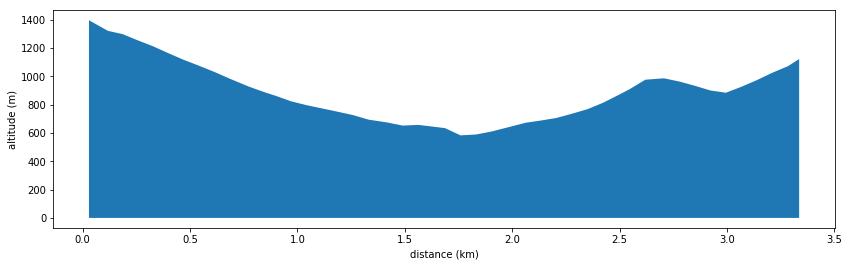

In [27]:
# graph
plt.figure(figsize=(14, 4))
plt.fill_between( R*np.array( theta_span), 0, ele_span );
plt.xlabel('distance (km)'); plt.ylabel('altitude (m)');

## Prise en compte courbure de la Terre

L'astuce est d'ajouter au profil de hauteur, la hauteur du sol par rapport à la corde $\delta$ entre les deux points A et B:
![sch_courbureTerre](./images/sch_courbureTerre.png)

In [28]:
delta_courbure = R*( 1- np.cos(theta_span[-1]/2 )/np.cos( theta_span - theta_span[-1]/2 ) )*1e3

elevation_reel = np.array( ele_span )  + delta_courbure

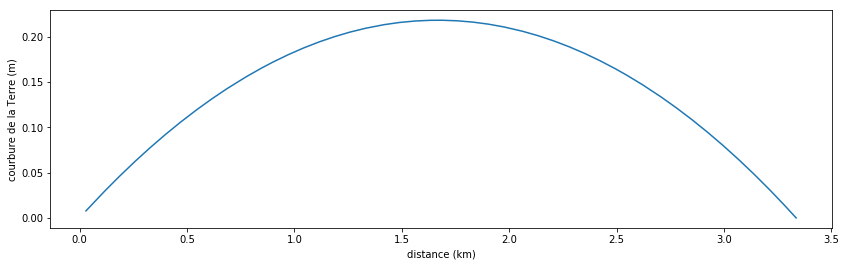

In [29]:
# graph
plt.figure(figsize=(14, 4))
plt.plot( R*np.array(theta_span), delta_courbure );
plt.xlabel('distance (km)'); plt.ylabel('courbure de la Terre (m)');

**Le sommet est visible si la différence entre la _ligne de vue_ et le profil de hauteur est toujours postive. **

In [40]:
# Calcul de la "ligne de vue" :
x = R*np.array( theta_span )
y = elevation_reel
ligne_de_vue = x*(y[-1]-y[0])/(x[-1]-x[0]) + y[0]

# Test si le sommet est visible ou non :
marge = 2 # mètre
visible = ((ligne_de_vue - elevation_reel)[1:-1] > -marge ).all()

visible

True

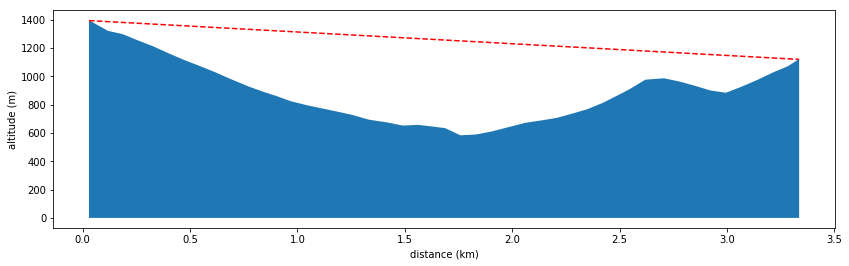

In [43]:
# graph
plt.figure(figsize=(14, 4))
plt.fill_between( R*np.array( theta_span), 0, elevation_reel )
plt.plot( R*np.array( theta_span), ligne_de_vue, "--r" );
plt.xlabel('distance (km)'); plt.ylabel('altitude (m)');

# pour la suite

* faire l'interpolation proprement en coord. sphérique
* prendre en compte la refraction de l'air


* Calcul de la position de l'horizon et des zones visibles

voir aussi [sherrytowers.com -calculating-the-horizon-profile](http://sherrytowers.com/2014/04/13/archeoastronomy-calculating-the-horizon-profile-using-online-us-geographic-survey-data/)